In [0]:
%load_ext rpy2.ipython
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

data = pd.read_csv('Kepler.csv')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


#Exploring the Dataset

In [0]:
#Convenience functions

def write_df(data, name = 'Kepler_from_python.csv'):
  data.to_csv( './'+name,index = False)

In [0]:
#Remove all indefinite cells since we can't test them, maybe look at them later

data = data[data['koi_disposition'] != 'CANDIDATE']
data.index = range(data.shape[0] )

In [0]:
#Column dropping, all in one place so it can all be rerun in one go


data.drop(['kepid', 'kepoi_name', 'kepler_name'], axis = 1, inplace = True)

data.drop('rowid', axis = 1, inplace = True)

data.drop('koi_tce_delivname', axis = 1, inplace = True)

data.drop('koi_tce_plnt_num', axis = 1, inplace = True)


'''Last checked is koi_fpflag_ec'''

#Column renaming to get rid of redundant 'koi_' at beginning of each name
data.columns = list(a.lstrip('koi_') for a in data.columns)

data.head(5)

,disposition,pdisposition,score,fpflag_nt,fpflag_ss,fpflag_co,fpflag_ec,period,period_err1,period_err2,time0bk,time0bk_err1,time0bk_err2,mpact,mpact_err1,mpact_err2,duration,duration_err1,duration_err2,depth,depth_err1,depth_err2,prad,prad_err1,prad_err2,teq,teq_err1,teq_err2,nsol,nsol_err1,nsol_err2,model_snr,steff,steff_err1,steff_err2,slogg,slogg_err1,slogg_err2,srad,srad_err1,srad_err2,ra,dec,epmag
0,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [0]:
#Replace remaining non numeric columns with numeric type

data['disposition'] = data['disposition'].replace( {'FALSE POSITIVE' : 0, 'CONFIRMED' : 1} )

data['pdisposition'] = data['pdisposition'].replace( {'FALSE POSITIVE' : 0, 'CANDIDATE' : 1} )

data.head(5)

,disposition,pdisposition,score,fpflag_nt,fpflag_ss,fpflag_co,fpflag_ec,period,period_err1,period_err2,time0bk,time0bk_err1,time0bk_err2,mpact,mpact_err1,mpact_err2,duration,duration_err1,duration_err2,depth,depth_err1,depth_err2,prad,prad_err1,prad_err2,teq,teq_err1,teq_err2,nsol,nsol_err1,nsol_err2,model_snr,steff,steff_err1,steff_err2,slogg,slogg_err1,slogg_err2,srad,srad_err1,srad_err2,ra,dec,epmag
0,1,1,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,1,1,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,0,0,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,0,0,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,1,1,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [0]:
#Returns every remaining column that has missing data along with ratios

def missing_sorted():
  missing_data = list( (cname, data[cname].isna().mean() ) for cname in data.columns if data[cname].isna().sum() != 0)
  return sorted(missing_data, key = lambda x : x[1], reverse = True)

#Imputation & dealing with NaNs

This plots the number of samples that are missing each number of features

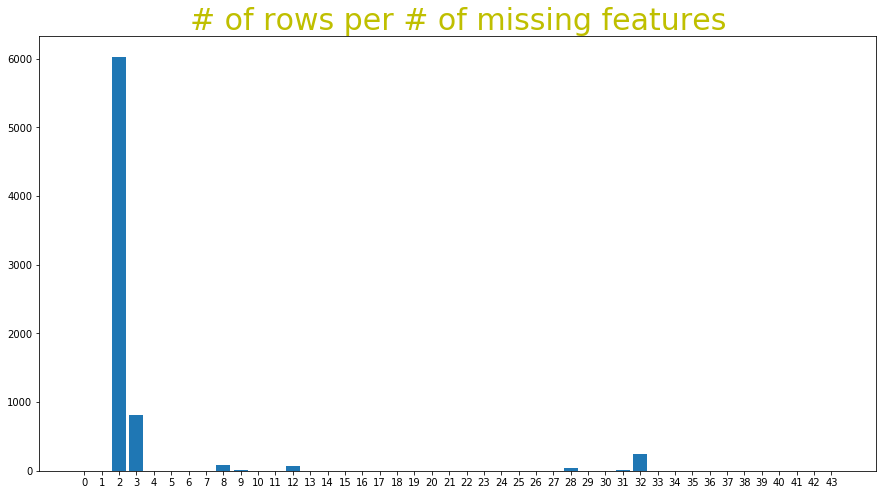

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x_bins = [0] * len(data.columns)

for row in data.iterrows():
  x_bins[sum(row[1].isna() )] += 1

_ = plt.figure(figsize = (15, 8) ) #(x, y)
_ = plt.bar(range(len(x_bins) ), x_bins, align = 'center' )
_ = plt.xticks(range(len(x_bins) ), range(len(x_bins) ) )
_ = plt.title(label = '# of rows per # of missing features', size = 30, color = 'y')

I am going to proceed by dropping samples with too many NaNs. My primary concern is that some missing features may have low, or even zero significance, so samples that have high NaNs at first might actually be less unimportant than previously thought. I will address this later.

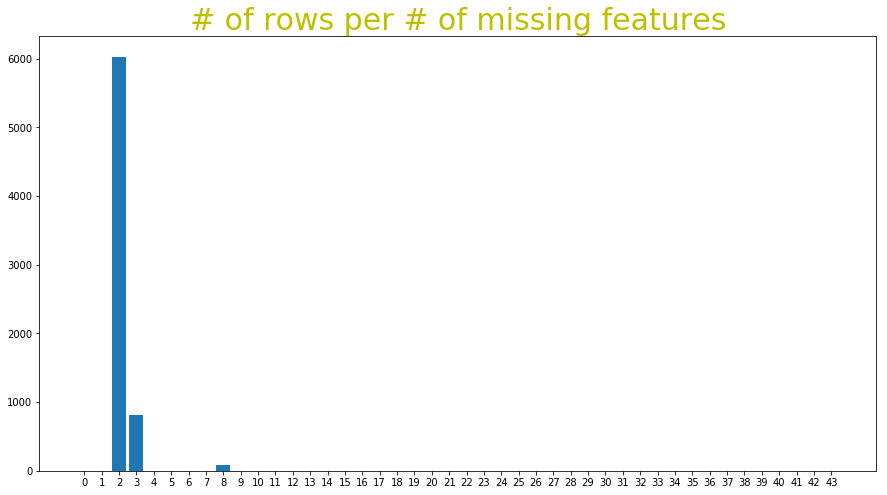

In [0]:
#Dropping samples missing >= 9 features

data = data.drop( list(i[0] for i in data.iterrows() if sum(i[1].isna() ) >= 9 ), axis = 0 )

data.index = range(data.shape[0] )

x_bins = [0] * len(data.columns)

for row in data.iterrows():
  x_bins[sum(row[1].isna() )] += 1

_ = plt.figure(figsize = (15, 8) ) #(x, y)
_ = plt.bar(range(len(x_bins) ), x_bins, align = 'center' )
_ = plt.xticks(range(len(x_bins) ), range(len(x_bins) ) )
_ = plt.title(label = '# of rows per # of missing features', size = 30, color = 'y')

In [0]:
missing_sorted()

[('teq_err1', 1.0),
 ('teq_err2', 1.0),
 ('score', 0.11526794742163801),
 ('steff_err2', 0.013577928643651597),
 ('steff_err1', 0.011411237902643362),
 ('slogg_err1', 0.011411237902643362),
 ('slogg_err2', 0.011411237902643362),
 ('srad_err1', 0.011411237902643362),
 ('srad_err2', 0.011411237902643362)]

In [0]:
#Drop these cols since 100% are missing

data.drop(['teq_err1', 'teq_err2'], axis = 1, inplace = True)

In [0]:
missing_sorted()

[('score', 0.11526794742163801),
 ('steff_err2', 0.013577928643651597),
 ('steff_err1', 0.011411237902643362),
 ('slogg_err1', 0.011411237902643362),
 ('slogg_err2', 0.011411237902643362),
 ('srad_err1', 0.011411237902643362),
 ('srad_err2', 0.011411237902643362)]

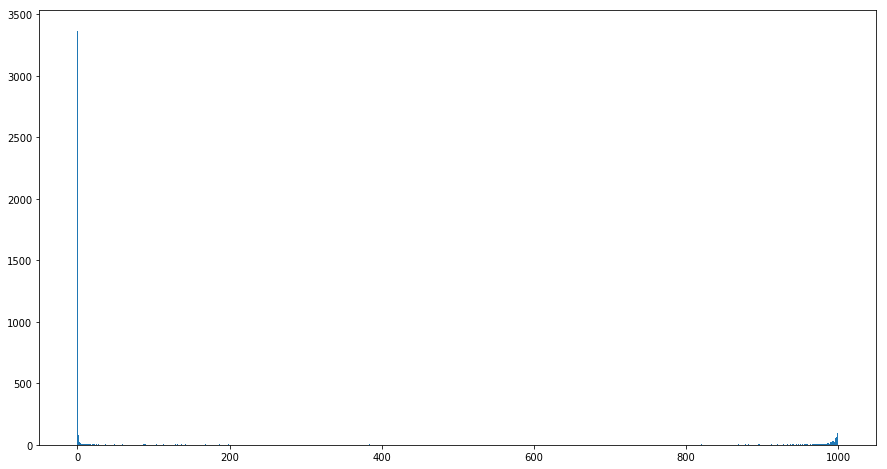

In [0]:
vals = list()

for row in data.iterrows():
  if not np.isnan(row[1]['score']):
    vals.append(row[1]['score'])
    
vals = list( int(num * 1000) for num in vals )

_ = plt.figure(figsize = (15, 8) ) #(x, y)
_ = plt.hist(vals, bins = (max(vals) - min(vals) ) )

Since NaNs seem to be clustered, I will run linear regression starting with the column with the least NaNs to impute the NaNs, and moving up into the column with the most NaNs

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

regressor = LinearRegression(n_jobs = -1)

data_for_imputation = data.copy()
full_data = data.copy() #dont touch this, this is for getting na indexes

order = missing_sorted()[::-1]

data_for_imputation.drop( list(a[0] for a in missing_sorted() ), inplace = True, axis = 1 )

for colname, _ in order:
  
  impute_estimations = list()
  naindexes = list()

  for index in range(full_data.shape[0] ):
    if pd.isna(data[colname][index]):
      naindexes.append(index)

  cleanindexes = list(a for a in range(full_data.shape[0] ) if a not in naindexes )

  target = full_data[colname][ ~pd.isna(full_data[colname]) ]

  base   = data_for_imputation[ ~pd.isna(full_data[colname]) ]

  base_unknown = data_for_imputation[ pd.isna(full_data[colname]) ]

  regressor.fit(base, target)

  impute_estimations = list(regressor.predict(base_unknown) )

  for index in naindexes:
    data[colname][index] = impute_estimations[0]
    impute_estimations.pop(0)

  data_for_imputation[colname] = data[colname].copy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

# Feature Exploration

In [0]:
train, test = train_test_split(data, train_size = .7, random_state = 817812019)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

train_X = train.iloc[:,1:]
train_y = train.iloc[:,0]

test_X = test.iloc[:,1:]
test_y = test.iloc[:,0]

##Feature Selection/Denoising using LASSO

###I will run LASSO twice - the first time for removing features that don't contribute and features that are mostly shadowed by noise, and the second for observing stronger prediction signal contributions when the stronger predictors are isolated from the noise

In [0]:
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()

scaled_train_X = scaler.fit_transform(train_X)

logreg = LogisticRegression(n_jobs = -1, penalty = 'l1', verbose = 4)

logreg.fit(scaled_train_X, train_y)

print(logreg.coef_, logreg.intercept_)

[LibLinear][[ 7.28331609e+00  1.04948809e+00 -1.13521158e-01 -1.88421362e-01
  -6.72920577e-01 -1.08508222e+00  3.94024832e-02 -3.98180423e-01
   1.86048754e-01  5.08828702e-02  0.00000000e+00 -2.01821789e-02
  -5.35365049e-01 -9.61970975e-01  0.00000000e+00  1.00190065e-01
  -9.28179705e-01  2.00968566e-01 -1.48536480e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -8.79858256e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -8.25533520e-01  2.46822820e-01 -2.69873354e-01  8.96850519e-01
   1.52129809e-03  1.91755985e-01  5.55083350e-01 -8.91607192e-02
  -9.95832515e-01  0.00000000e+00 -5.52595567e-02  7.29214698e-02
   0.00000000e+00]] [0.]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


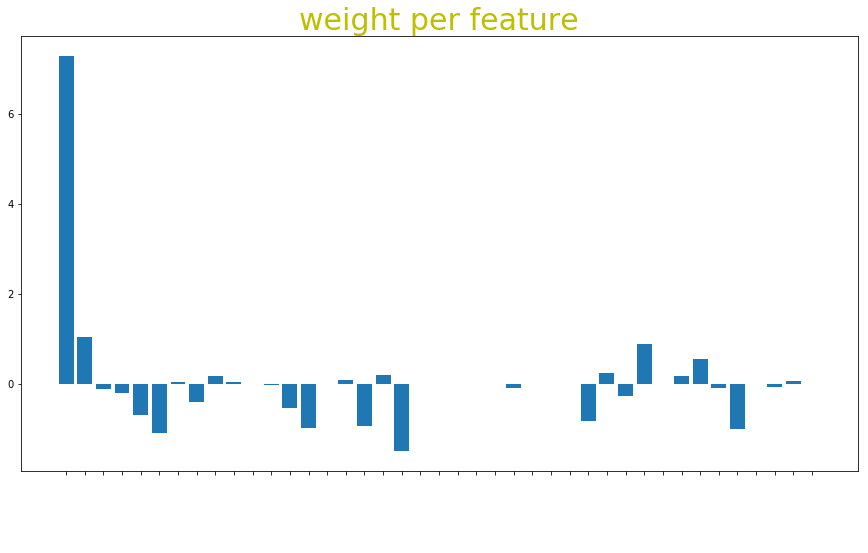

In [0]:
_ = plt.figure(figsize = (15, 8) ) #(x, y)

_ = plt.bar(range(len(logreg.coef_[0] ) ), logreg.coef_[0], align = 'center' )

_ = plt.xticks(range(len(logreg.coef_[0]) ), data.columns[1:], color = 'w', rotation = 'vertical' )

_ = plt.title(label = 'weight per feature', size = 30, color = 'y')

In [0]:
z = zip(logreg.coef_[0], data.columns[1:] )
z_sorted = sorted(list(z), key = lambda x : -abs(x[0]) )
z_sorted

[(7.283316088134279, 'pdisposition'),
 (-1.4853648046821277, 'depth'),
 (-1.08508222108908, 'fpflag_ec'),
 (1.049488086036865, 'score'),
 (-0.9958325146621064, 'srad_err1'),
 (-0.9619709754134725, 'mpact_err1'),
 (-0.9281797050184606, 'duration_err1'),
 (0.8968505187134684, 'steff_err2'),
 (-0.8255335200684286, 'model_snr'),
 (-0.6729205772516476, 'fpflag_co'),
 (0.5550833504490289, 'slogg_err2'),
 (-0.5353650486463158, 'mpact'),
 (-0.3981804227864444, 'period_err1'),
 (-0.26987335449635724, 'steff_err1'),
 (0.2468228202840267, 'steff'),
 (0.20096856561305887, 'duration_err2'),
 (0.19175598490956391, 'slogg_err1'),
 (-0.18842136224243486, 'fpflag_ss'),
 (0.1860487537498109, 'period_err2'),
 (-0.11352115808864711, 'fpflag_nt'),
 (0.10019006466969377, 'duration'),
 (-0.08916071915293185, 'srad'),
 (-0.08798582564136462, 'teq'),
 (0.07292146982863641, 'dec'),
 (-0.055259556726519096, 'ra'),
 (0.05088287022490969, 'time0bk'),
 (0.039402483232790754, 'period'),
 (-0.020182178874215126, 'tim

In [0]:
zero_importance = list(a[1] for a in z_sorted if a[0] == 0)
data.drop(zero_importance, axis = 1, inplace = True)

In [0]:
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()

scaled_train_X = scaler.fit_transform(train_X.drop(zero_importance, axis = 1) )

logreg = LogisticRegression(n_jobs = -1, penalty = 'l1', verbose = 4)

logreg.fit(scaled_train_X, train_y)

print(logreg.coef_, logreg.intercept_)

[LibLinear][[ 7.16518354e+00  1.10726015e+00 -1.23798192e-01 -1.98820608e-01
  -6.76017039e-01 -1.06906906e+00  3.79700530e-02 -1.23566577e-01
   4.51777936e-01  5.10267532e-02 -1.86854014e-02 -5.25239872e-01
  -9.34414271e-01  1.01387940e-01 -5.72068708e-01  5.47586629e-01
  -1.44078076e+00 -8.34500633e-02 -8.19207884e-01  2.46765866e-01
  -2.61040325e-01  8.99956077e-01  4.77995091e-03  1.87327253e-01
   5.52573824e-01 -8.61349853e-02 -9.80026707e-01 -5.36652820e-02
   7.33117756e-02]] [0.]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


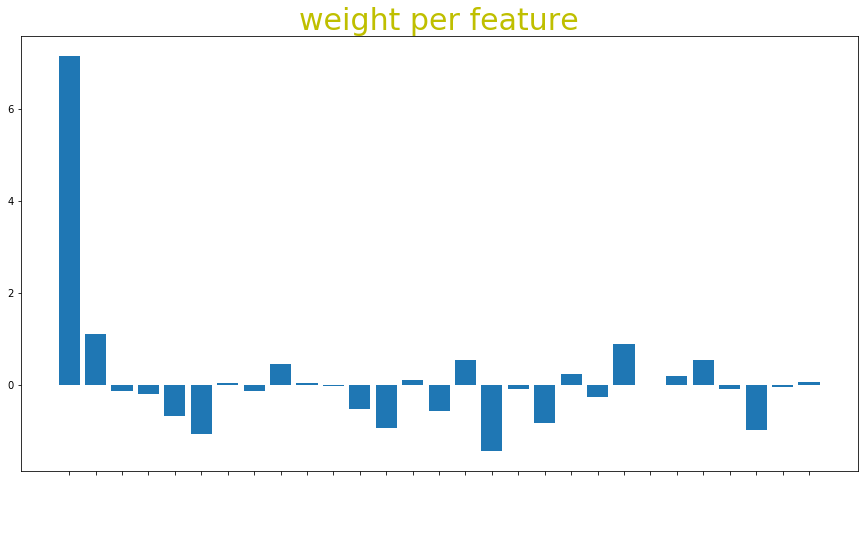

In [0]:
_ = plt.figure(figsize = (15, 8) ) #(x, y)

_ = plt.bar(range(len(logreg.coef_[0] ) ), logreg.coef_[0], align = 'center' )

_ = plt.xticks(range(len(logreg.coef_[0]) ), data.columns[1:], color = 'w', rotation = 'vertical' )

_ = plt.title(label = 'weight per feature', size = 30, color = 'y')

In [0]:
second_gen = zip(logreg.coef_[0], data.columns[1:])
second_gen_sorted = sorted(list(second_gen), key = lambda x : -abs(x[0]) )
print(z_sorted)
print(second_gen_sorted)

[(7.283316088134279, 'pdisposition'), (-1.4853648046821277, 'depth'), (-1.08508222108908, 'fpflag_ec'), (1.049488086036865, 'score'), (-0.9958325146621064, 'srad_err1'), (-0.9619709754134725, 'mpact_err1'), (-0.9281797050184606, 'duration_err1'), (0.8968505187134684, 'steff_err2'), (-0.8255335200684286, 'model_snr'), (-0.6729205772516476, 'fpflag_co'), (0.5550833504490289, 'slogg_err2'), (-0.5353650486463158, 'mpact'), (-0.3981804227864444, 'period_err1'), (-0.26987335449635724, 'steff_err1'), (0.2468228202840267, 'steff'), (0.20096856561305887, 'duration_err2'), (0.19175598490956391, 'slogg_err1'), (-0.18842136224243486, 'fpflag_ss'), (0.1860487537498109, 'period_err2'), (-0.11352115808864711, 'fpflag_nt'), (0.10019006466969377, 'duration'), (-0.08916071915293185, 'srad'), (-0.08798582564136462, 'teq'), (0.07292146982863641, 'dec'), (-0.055259556726519096, 'ra'), (0.05088287022490969, 'time0bk'), (0.039402483232790754, 'period'), (-0.020182178874215126, 'time0bk_err2'), (0.00152129808

In the second run, the magnitudes of the weights are larger, but some positions are swapped, implying some out of the remaining features are pairwise or groupwise correlated. I will run PCA to decorrelate the features so I can use a smaller feature space.

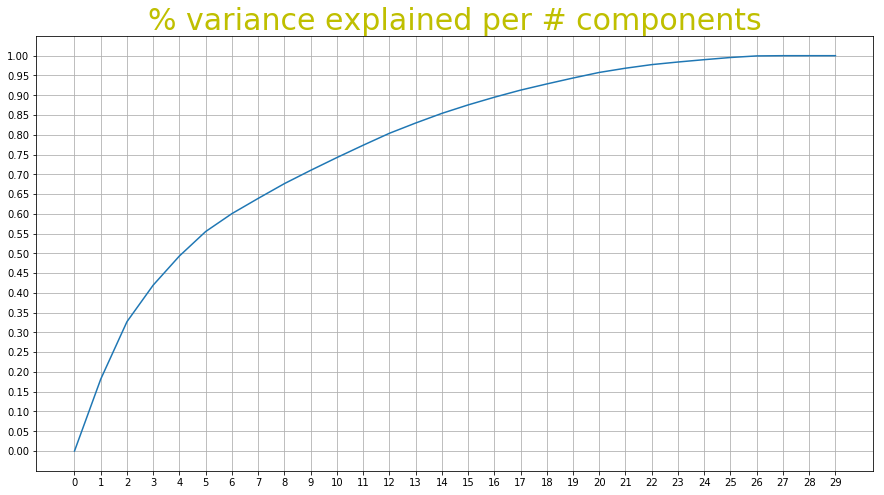

In [0]:
lasso_train_X = train_X.drop(zero_importance, axis = 1)

from sklearn.decomposition import PCA

pca = PCA()

pca_scaler = StandardScaler()
scaled_lasso_train_X = pca_scaler.fit_transform(lasso_train_X)

pca.fit(scaled_lasso_train_X)

_ = plt.figure(figsize = (15, 8) )
_ = plt.grid()
_ = plt.xticks( range(len(pca.explained_variance_ratio_) + 1 ) )
_ = plt.yticks( np.arange(0,1.05,.05) )
_ = plt.plot( range(len(pca.explained_variance_ratio_) + 1 ), list( sum(pca.explained_variance_ratio_[:num_comps] ) for num_comps in range(1 + len(pca.explained_variance_ratio_) ) ) )
_ = plt.title( label = '% variance explained per # components', size = 30, color = 'y' )

We only need 19 Principal Components to describe 95% of the variance in the data.

In [0]:
component_reduced_train_X = pca.transform(scaled_lasso_train_X)
component_reduced_train_X = np.array( list(vec[:19] for vec in component_reduced_train_X ) )

#Modeling

##ElasticNet + GridSearchCV

In [0]:
enet = LogisticRegression(penalty = 'elasticnet', n_jobs = -1, solver = 'saga')
from sklearn.model_selection import GridSearchCV

prenet_scaler = StandardScaler()
comp_reduced_scaled_train_X = prenet_scaler.fit_transform(component_reduced_train_X)

param_grid = {
    'l1_ratio' : np.arange(0, 1.05, .05)
}

GSCV = GridSearchCV(enet, param_grid = param_grid, n_jobs = -1, verbose = 5, cv = 5)

GSCV.fit(comp_reduced_scaled_train_X, train_y)


Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   18.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=-1, penalty='elasticnet',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [0]:
print('Best params are', GSCV.best_params_)

best_enet = GSCV.best_estimator_

def pipeline(data):
  lasso_data = data.drop(zero_importance, axis = 1)
  scaled_lasso_data = pca_scaler.transform(lasso_data)
  reduced_scaled_lasso_data = pca.transform(scaled_lasso_data)
  reduced_pcomp = np.array(list(vec[:19] for vec in reduced_scaled_lasso_data) )
  reduced_pcomp_scaled = prenet_scaler.transform(reduced_pcomp)
  return reduced_pcomp_scaled

transformed_test_X = pipeline(test_X)

predicted = best_enet.predict(transformed_test_X)

confusion_matrix(y_pred = predicted, y_true = test_y)

Best params are {'l1_ratio': 0.0}


array([[1380,    0],
       [  18,  679]])

The ElasticNet converged to Ridge Regression on its own through Grid Search.

##Support Vector Machine + GridSearchCV

For SVM, since there are a lot of parameters and the runtime scales by n^2, I can't brute force grid search unless I want it to take 4 hours. I will start a wide grid search and zoom in on grid lines of interest

In [0]:
from sklearn.svm import SVC

param_grid = [
    {
        'C' : list(np.arange(start = .25, stop = 1.1, step = .25) ),
        'kernel' : ['rbf'],
        'gamma' : list(np.arange(start = .3, stop = 1.51, step = .3) )
    },
    {
        'C' : list(np.arange(start = .25, stop = 1.1, step = .25) ),
        'kernel' : ['poly'],
        'gamma' : list(np.arange(start = .3, stop = 1.51, step = .3) ),
        'degree' : list(np.arange(start = 1, stop = 5) )
    }
]

svc = SVC()

GSCV = GridSearchCV(svc, param_grid = param_grid, n_jobs = -1, verbose = 5, cv = 5)
GSCV.fit(comp_reduced_scaled_train_X, train_y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 358 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [0.25, 0.5, 0.75, 1.0],
                          'gamma': [0.3, 0.6, 0.8999999999999999, 1.2, 1.5],
                          'kernel': ['rbf']},
                         {'C': [0.25, 0.5, 0.75, 1.0], 'degree': [1, 2, 3, 4],
                          'gamma': [0.3, 0.6, 0.8999999999999999, 1.2, 1.5],
                          'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [0]:
print(GSCV.best_params_)

confusion_matrix(y_pred = GSCV.best_estimator_.predict(transformed_test_X), y_true = test_y)

{'C': 0.25, 'degree': 1, 'gamma': 0.3, 'kernel': 'poly'}


array([[1380,    0],
       [  18,  679]])

In [0]:
param_grid = {
        'C' : list(np.arange(start = .001, stop = .26, step = .05) ),
        'kernel' : ['poly'],
        'gamma' : list(np.arange(start = 0, stop = .31, step = .05) ),
        'degree' : list(np.arange(start = 1, stop = 5) )
    }

svc = SVC()

GSCV = GridSearchCV(svc, param_grid = param_grid, n_jobs = -1, verbose = 5, cv = 5)
GSCV.fit(comp_reduced_scaled_train_X, train_y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:  2.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.051000000000000004, 0.101,
                               0.15100000000000002, 0.201, 0.251],
                         'degree': [1, 2, 3, 4],
                         'gamma': [0.0, 0.05, 0.1, 0.15000000000000002, 0.2,
                                   0.25, 0.30000000000000004],
                         'kernel': ['poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [0]:
print(GSCV.best_params_)
confusion_matrix(y_pred = GSCV.best_estimator_.predict(transformed_test_X), y_true = test_y)

{'C': 0.051000000000000004, 'degree': 1, 'gamma': 0.05, 'kernel': 'poly'}


array([[1380,    0],
       [  18,  679]])